# Predict substructure fingerprints from spectra

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import csv

import numpy as np
import pandas as pd

import keras
from keras.callbacks import History, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from livelossplot import PlotLossesKeras

from ms2lda_feature_extraction import LoadMSP, LoadGNPS, LoadMGF, LoadGNPSSeperateCollisions
from functions import *

Using TensorFlow backend.


### Load GNPS+Massbank data

- predictive performance per fingerprint bins
- siwtch one fragment on, and see the output
- cdk can give all the fragments of a molecule
- try neutral losses as input?
- a peak has to be in the top-6 peaks in a sliding window

Data contains SMILES of known molecules and also their fragmentation spectra from massbank + gnps.

Collision energies are merged.

In [3]:
# input_dir = '../data/spectra_gnps_massbank'
# input_set = glob.glob(input_dir + '/*.ms')
# l = LoadGNPS()
# ms1, ms2, metadata = l.load_spectra(input_set)

In [4]:
# def make_spec_matrix(ms1, ms2, min_frag_mz=20, max_frag_mz=500, normalise=1000.0):
#     doc_index = {}
#     n_docs = len(ms1)
#     i = 0
#     for m in ms1:
#         doc_index[m.name] = i
#         i += 1
#     n_words = max_frag_mz - min_frag_mz + 1
#     n_docs = len(doc_index)
#     doc_matrix = np.zeros((n_docs,n_words),np.double)
#     for m in ms2:
#         mz = m[0]
#         mz_int = (int)(np.round(mz))
#         doc_pos = doc_index[m[3].name]
#         if mz_int <= max_frag_mz and mz_int >= min_frag_mz:
#             mz_pos = mz_int - min_frag_mz
#             doc_matrix[doc_pos,mz_pos] += m[2]
            
#     s = doc_matrix.sum(axis=1)
#     toremove = []
#     for doc,doc_pos in doc_index.items():
#         if s[doc_pos] == 0:
#             toremove.append(doc)
    
#     for doc in toremove:
#         doc_pos = doc_index[doc]
#         doc_matrix = np.delete(doc_matrix,(doc_pos),axis=0)
#         del doc_index[doc]
#         for d,p in doc_index.items():
#             if p > doc_pos:
#                 doc_index[d] -= 1
    
#     if normalise > 0:
#         s = doc_matrix.max(axis=1)
#         s = s[:,None]
#         doc_matrix *= (normalise/s)

#     return doc_index, doc_matrix

In [5]:
# min_frag_mz = 20
# max_frag_mz = 900
# normalise = 1.0
# spectra_index, spectra_matrix = make_spec_matrix(ms1, ms2, min_frag_mz, max_frag_mz, normalise)

In [6]:
# smiles = pd.read_csv('../data/smiles_list.smi', header=None)
# smiles = smiles.values.flatten().tolist()

In [7]:
# data = {
#     'vocab': np.arange(min_frag_mz, max_frag_mz+1),
#     'spectra': doc_matrix,
#     'doc_index': doc_index,
#     'metadata': metadata,
#     'smiles': smiles
# }

In [8]:
# with open('../data/gnps_massbank_data.p', 'wb') as f:
#     pickle.dump(data, f)

Load pre-binned data using the code above

In [9]:
with open('../data/gnps_massbank_data.p', 'rb') as f:
    data = pickle.load(f)

In [10]:
spectra = data['spectra']

### Create  Fingerprints of Molecules

Load substructures fingerprints generated by CDK for the smiles corresponding to the spectra above.

In [11]:
fprints = {}
with open('../data/smiles_sub.csv','r') as f:
    reader = csv.reader(f)
    for line in reader:
        fprints[line[0]] = [int(i) for i in line[1:]]

In [12]:
smiles = data['smiles']
fingerprint_arr = np.zeros((len(smiles), 306+1))
for i in range(len(smiles)):
    smile = smiles[i]
    fingerprint = fprints[smile]
    for bit in fingerprint:
        fingerprint_arr[i][bit] = 1

(7901, 881)


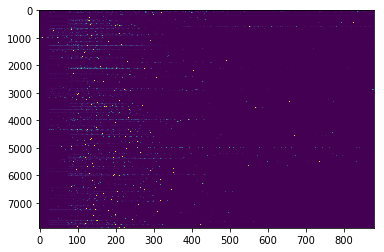

In [13]:
print(spectra.shape)
plt.imshow(spectra,aspect='auto')

(7901, 307)


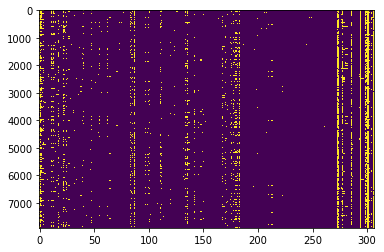

In [14]:
print(fingerprint_arr.shape)
plt.imshow(fingerprint_arr,aspect='auto')

Plot some spectra and their fingerprints

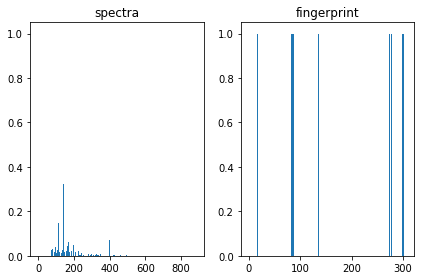

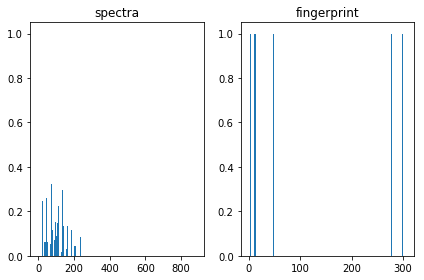

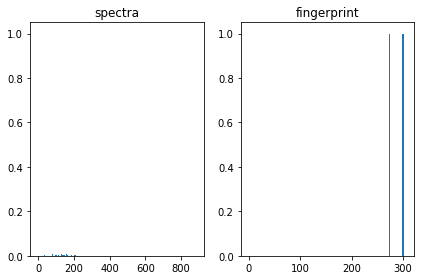

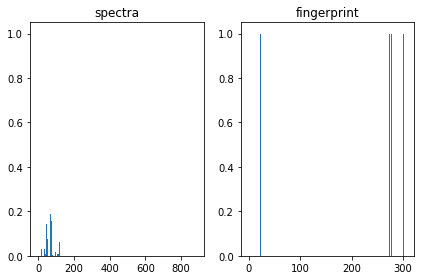

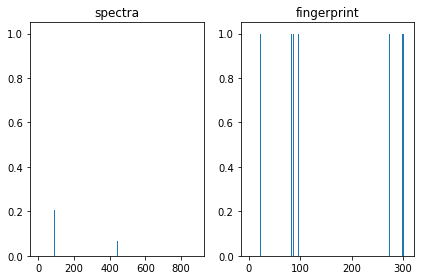

In [15]:
def plot_spectra_and_fingerprint(idx):
    plt.subplot(121)
    plt.bar(np.arange(len(spectra[idx])), spectra[idx])
    plt.title('spectra')
    plt.subplot(122)
    plt.bar(np.arange(len(fingerprint_arr[idx])), fingerprint_arr[idx])
    plt.title('fingerprint')
    plt.tight_layout()
    plt.show()
    
for i in range(5):
    plot_spectra_and_fingerprint(i)

### Filtering

In [16]:
substructures = []
with open('../data/substructures.txt','r') as f:
    for line in f:
        substructures.append(line.strip())

In [17]:
s = fingerprint_arr.sum(axis=0)
sub_count = []
for i, sub in enumerate(substructures):
    sub_count.append((i, sub, s[i]))

sub_count = sorted(sub_count,key = lambda x: x[1],reverse = True)
count_df = pd.DataFrame(sub_count, columns=['pos', 's', 'c'])
count_df = count_df.sort_values(by=['c'], ascending=False)

In [18]:
cdk_sub_df = pd.read_csv('../data/cdk_substructures.csv')
df = pd.merge(count_df, cdk_sub_df, left_on='s', right_on='Pattern').drop(['Bit position', 'Pattern'], axis=1)

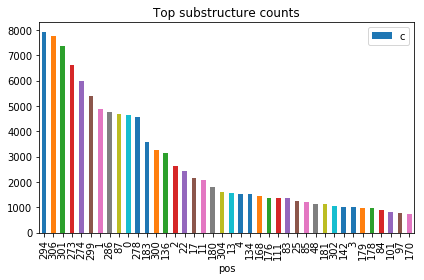

In [19]:
df.head(40).plot(kind='bar', x='pos', y='c')
plt.title('Top substructure counts')
plt.tight_layout()

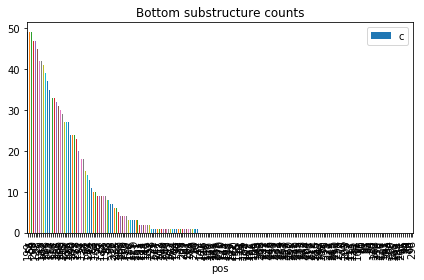

In [20]:
df.tail(200).plot(kind='bar', x='pos', y='c')
plt.title('Bottom substructure counts')
plt.tight_layout()

We use only substructures with lower < counts < upper for the target predictions

In [21]:
lower = 10
upper = 3000

In [22]:
keep = df[(df['c'] > lower) & (df['c'] < upper)]
print(df.shape)
print(keep.shape)

(307, 4)
(127, 4)


Text(0.5,1,'Substructures 10 < counts < 3000')

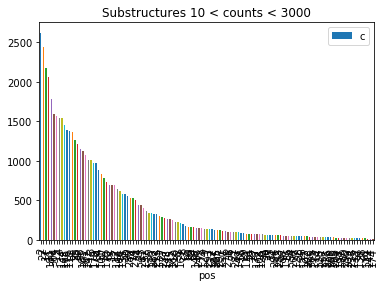

In [23]:
keep.plot(kind='bar', x='pos', y='c')
plt.title('Substructures %d < counts < %d' % (lower, upper))

Select rows and columns to keep from fp_mat and spectra

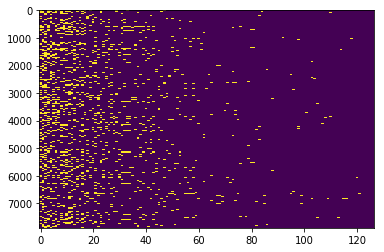

In [24]:
keep_idx = keep['pos'].values
fp_mat = fingerprint_arr[:, keep_idx]

nnz_pos = ~(fp_mat==0).all(1) # find rows that are not all zeros
fp_mat = fp_mat[nnz_pos]
spectra = spectra[nnz_pos]

plt.imshow(fp_mat,aspect='auto')

### Try mapping spectra and fingerprints

In [25]:
def get_model(input_dim, output_dim, latent_dim):

    input_layer = Input(shape=(input_dim,))
    encoded = Dense(latent_dim, activation='relu')(input_layer)
    encoded = Dense(latent_dim, activation='relu')(encoded)    
    encoded = Dropout(0.5)(encoded)
    decoded = Dense(output_dim, activation='sigmoid')(encoded)        
    loss = 'binary_crossentropy'
    
    autoencoder = Model(input_layer, decoded)
    encoder = Model(input_layer, encoded)

    encoded_input = Input(shape=(latent_dim,))
    decoder_layer = autoencoder.layers[-1]
    decoder = Model(encoded_input, decoder_layer(encoded_input))

    autoencoder.compile(optimizer='adam', loss=loss)
    return autoencoder, encoder, decoder

In [26]:
def compute_performance(y_pred_arr, y_true_arr):
    total_tp = 0
    total_fp = 0
    total_fn = 0
    for i in range(len(y_true_arr)):

        y_pred = np.round(y_pred_arr[i])
        y_true = y_true_arr[i]    
        y_pred_nnz = set(np.nonzero(y_pred)[0].tolist())
        y_true_nnz = set(np.nonzero(y_true)[0].tolist())    

        # tp = selected and relevant
        tp = y_pred_nnz & y_true_nnz
        total_tp += len(tp)

        # fp = selected but not relevant
        fp = y_pred_nnz - y_true_nnz
        total_fp += len(fp)

        # fn = not selected but relevant
        fn = y_true_nnz - y_pred_nnz
        total_fn += len(fn)

    try:
        precision = total_tp / float(total_tp + total_fp)
    except ZeroDivisionError:
        precision = 0.0
    try:
        recall = total_tp / float(total_tp + total_fn)
    except ZeroDivisionError:
        recall = 0.0
    try:
        f1 = 2 * (precision * recall) / (precision + recall)
    except ZeroDivisionError:
        f1 = 0.0
    return precision, recall, f1

In [27]:
def plot_pred(y_pred_arr, y_true_arr, N=10, th=0, print_nnz=True):
    for i in range(N):
        if th == 0:            
            y_pred = np.round(y_pred_arr[i])
        else:
            y_pred = np.copy(y_pred_arr[i])
            pos = np.nonzero(y_pred < th)
            y_pred[pos] = 0
        y_true = y_true_arr[i]    

        if print_nnz:
            y_pred_nnz = set(np.nonzero(y_pred)[0].tolist())
            y_true_nnz = set(np.nonzero(y_true)[0].tolist())    
            print('y_true_nnz', y_true_nnz)
            print('y_pred_nnz', y_pred_nnz)        
        
        plt.bar(np.arange(len(y_true)), y_true)
        plt.bar(np.arange(len(y_pred)), -y_pred)
        plt.show()

In [28]:
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=10, min_lr=0.000001,
                        verbose=1, min_delta=1e-5)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')
callbacks = [rlr]
if is_notebook():
    callbacks.append(PlotLossesKeras())

In [29]:
pos = int(len(spectra) * 0.8)
spectra_train = spectra[0:pos, :]
spectra_test = spectra[pos:, :]
fingerprint_train = fp_mat[0:pos, :]
fingerprint_test = fp_mat[pos:, :]

#### Spectra to fingerprints

- Input: peak intensities, binned by their m/z integer values
- Output: substructural fingerprint bits

In [30]:
input_dim = spectra.shape[1]
output_dim = fp_mat.shape[1]
latent_dim = 100
batch_size = 10
epochs = 100

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 881)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               88200     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 127)               12827     
Total params: 111,127
Trainable params: 111,127
Non-trainable params: 0
_________________________________________________________________


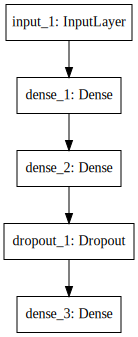

In [31]:
autoencoder, encoder, decoder = get_model(input_dim, output_dim, latent_dim)
autoencoder.summary()
plot_model_in_notebook(autoencoder)

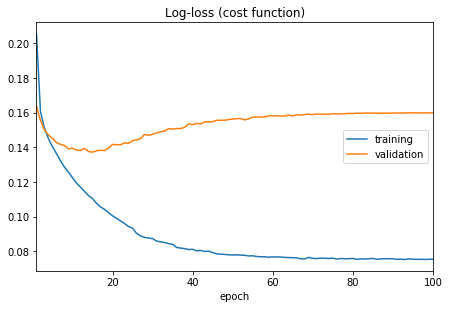

In [32]:
autoencoder.fit(spectra_train, fingerprint_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(spectra_test, fingerprint_test),
                callbacks=callbacks)

Training performance

In [33]:
latent = encoder.predict(spectra_train)
predicted_fingerprint = decoder.predict(latent)
precision, recall, f1 = compute_performance(predicted_fingerprint, fingerprint_train)
print('precision %.2f recall %.2f f1 %.2f' % (precision, recall, f1))
# plot_pred(predicted_fingerprint, fingerprint_train, N=10)

precision 0.93 recall 0.60 f1 0.73


Testing performance

In [34]:
latent = encoder.predict(spectra_test)
predicted_fingerprint = decoder.predict(latent)
precision, recall, f1 = compute_performance(predicted_fingerprint, fingerprint_test)
print('precision %.2f recall %.2f f1 %.2f' % (precision, recall, f1))
# plot_pred(predicted_fingerprint, fingerprint_test, N=10)

precision 0.67 recall 0.35 f1 0.46


Compute per-fingerprint-bit performance

In [35]:
n_spectra, n_fingerprints = predicted_fingerprint.shape
print(predicted_fingerprint.shape)

(1578, 127)


In [36]:
def compute_fp_bit_performance(y_pred, y_true):
    y_pred = np.round(y_pred)
    y_pred_nnz = set(np.nonzero(y_pred)[0].tolist())
    y_true_nnz = set(np.nonzero(y_true)[0].tolist())    

    # tp = selected and relevant
    tp = y_pred_nnz & y_true_nnz
    total_tp = len(tp)

    # fp = selected but not relevant
    fp = y_pred_nnz - y_true_nnz
    total_fp = len(fp)

    # fn = not selected but relevant
    fn = y_true_nnz - y_pred_nnz
    total_fn = len(fn)

    try:
        precision = total_tp / float(total_tp + total_fp)
    except ZeroDivisionError:
        precision = 0.0
    try:
        recall = total_tp / float(total_tp + total_fn)
    except ZeroDivisionError:
        recall = 0.0
    try:
        f1 = 2 * (precision * recall) / (precision + recall)
    except ZeroDivisionError:
        f1 = 0.0
    return total_tp, total_fp, total_fn, precision, recall, f1

In [37]:
keep.head()

,pos,s,c,Description
14,2,[CX4H1]([#6])([#6])[#6],2620.0,Tertiary carbon
15,22,"[NX3+0,NX4+;!$([N]~[!#6]);!$([N]*~[#7,#8,#15,#...",2444.0,Amine
16,17,"[OX2](c)[CX4;!$(C([OX2])[O,S,#7,#15,F,Cl,Br,I])]",2166.0,Alkylarylether
17,11,"[OX2H][CX4;!$(C([OX2H])[O,S,#7,#15])]",2060.0,Alcohol
18,180,"[nX2,nX3+]",1784.0,Hetero N nonbasic


In [42]:
data = []
for i in range(n_fingerprints):
    y_pred_arr = predicted_fingerprint[:, i]
    y_true_arr = fingerprint_test[:, i]
    s = keep.iloc[i]['s']
    pos = keep.iloc[i]['pos']
    desc = keep.iloc[i]['Description']
    tp, fp, fn, prec, rec, f1 = compute_fp_bit_performance(y_pred_arr, y_true_arr)
    data.append((s, pos, desc, tp, fp, fn, prec, rec, f1))
df = pd.DataFrame(data, columns=['Substructure', 'Bit position', 'Description', 'TP', 'FP', 'FN', 'precision', 'recall', 'f1'])

Text(0,0.5,'Performance')

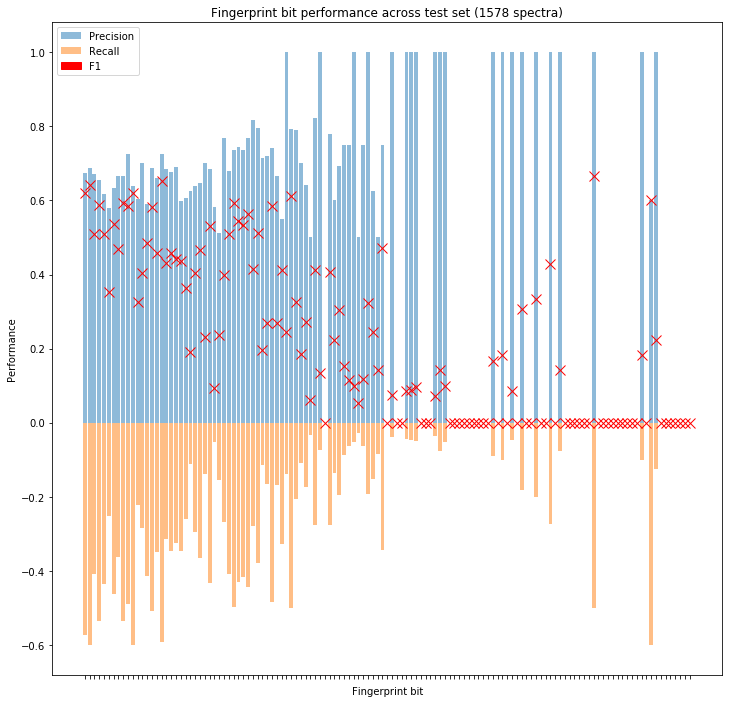

In [65]:
import matplotlib.patches as mpatches

plt.figure(figsize=(12,12))
p1 = plt.bar(range(n_fingerprints), df['precision'].values, alpha=0.5)
p2 = plt.bar(range(n_fingerprints), -df['recall'].values, alpha=0.5)
p3 = mpatches.Patch(color='red', label='F_1')
plt.plot(range(n_fingerprints), df['f1'].values, 'rx', markersize=10)
plt.title('Fingerprint bit performance across test set (%d spectra)' % n_spectra)
plt.legend([p1, p2, p3], ['Precision', 'Recall', 'F1'])
plt.xticks(np.arange(n_fingerprints), df['Bit position'].values)
ax = plt.gca()
# ax.xaxis.set_major_locator(plt.NullLocator())
ax.xaxis.set_major_formatter(plt.NullFormatter())
plt.xlabel('Fingerprint bit')
plt.ylabel('Performance')

In [48]:
df.head()

,Substructure,Bit position,Description,TP,FP,FN,precision,recall,f1
0,[CX4H1]([#6])([#6])[#6],2,Tertiary carbon,264,127,198,0.675192,0.571429,0.618992
1,"[NX3+0,NX4+;!$([N]~[!#6]);!$([N]*~[#7,#8,#15,#...",22,Amine,305,138,204,0.688488,0.599214,0.640756
2,"[OX2](c)[CX4;!$(C([OX2])[O,S,#7,#15,F,Cl,Br,I])]",17,Alkylarylether,178,87,257,0.671698,0.409195,0.508571
3,"[OX2H][CX4;!$(C([OX2H])[O,S,#7,#15])]",11,Alcohol,227,120,197,0.654179,0.535377,0.588846
4,"[nX2,nX3+]",180,Hetero N nonbasic,152,94,198,0.617886,0.434286,0.510067


In [66]:
df.to_csv('../data/cdk_test_pred.csv', index=None, float_format='%.3f')

#### Fingerprints to spectra

- Input: substructural fingerprint bits
- Output: peak intensities, binned by their m/z integer values

In [67]:
input_dim = fp_mat.shape[1]
output_dim = spectra.shape[1]
latent_dim = 64
batch_size = 32
epochs = 100

In [68]:
autoencoder, encoder, decoder = get_model(input_dim, output_dim, latent_dim)
autoencoder.summary()
# plot_model_in_notebook(autoencoder)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 127)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8192      
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 881)               57265     
Total params: 69,617
Trainable params: 69,617
Non-trainable params: 0
_________________________________________________________________


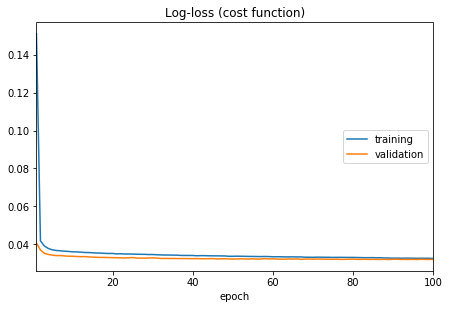

In [69]:
autoencoder.fit(fingerprint_train, spectra_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(fingerprint_test, spectra_test),
                callbacks=callbacks)

In [70]:
latent = encoder.predict(fingerprint_test)
predicted_spectra = decoder.predict(latent)

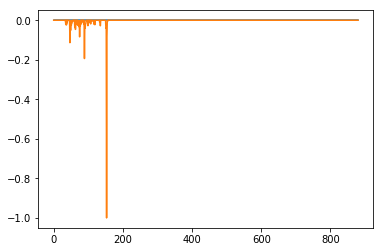

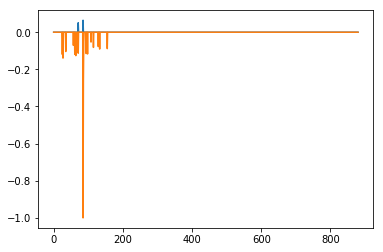

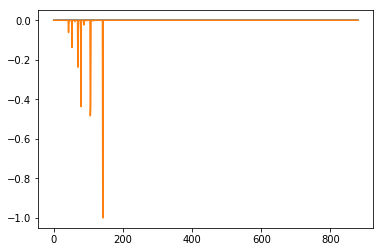

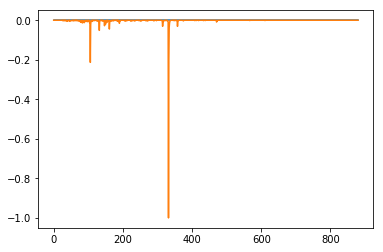

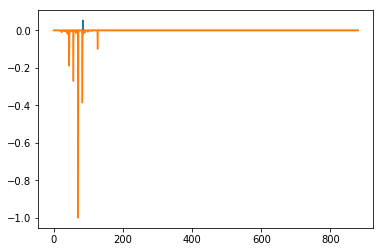

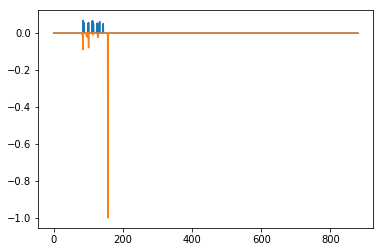

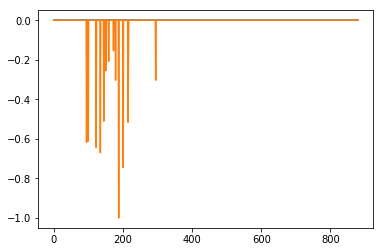

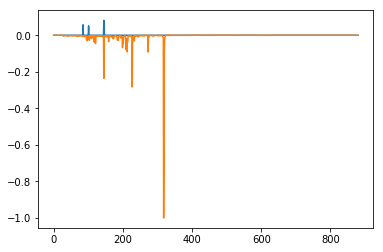

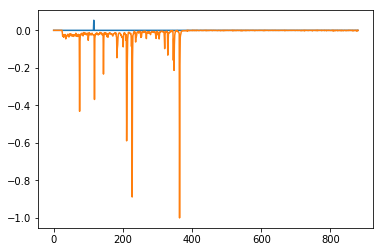

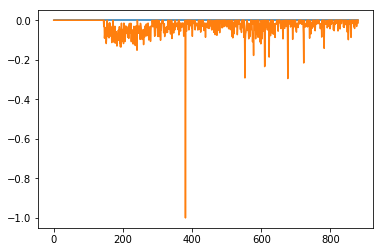

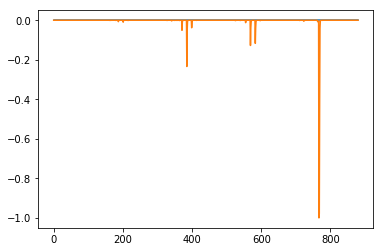

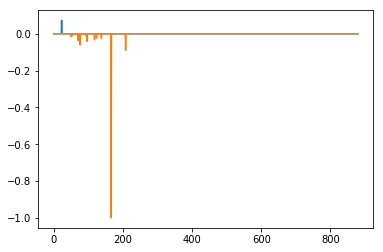

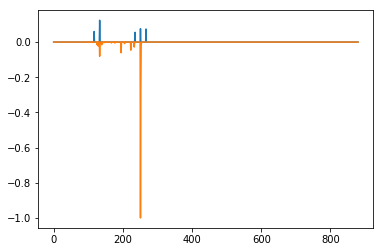

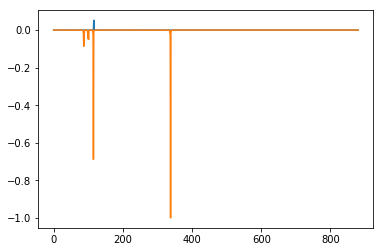

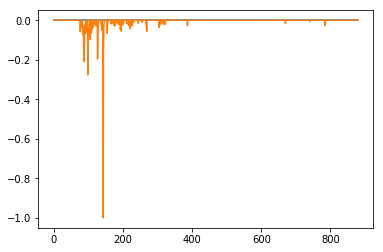

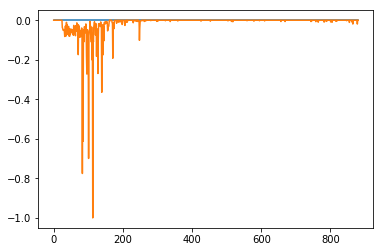

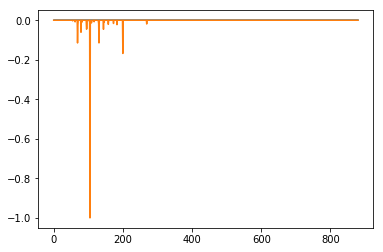

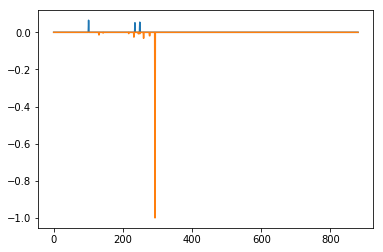

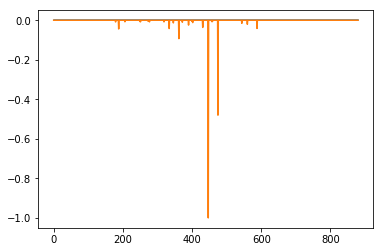

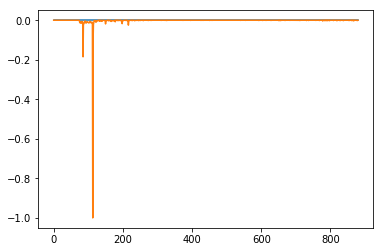

In [71]:
for i in range(20):
    y_pred = np.copy(predicted_spectra[i])
    pos = np.nonzero(y_pred < 0.05)
    y_pred[pos] = 0
    plt.plot(y_pred)

    y_true = spectra_test[i]
    plt.plot(-y_true)
    plt.show()